# Selection of events for NEMA3 

- Phantom : nema 3
- Events: all
- Detector geometry: SiPMs in LXe, with Hamamatsu sipms
- Time resolution: 50 ps
- qcut > 1 pes
- ntof > 7
- PDE = 0.3
- LXe = 20 mm

In [1]:
using Pkg
Pkg.activate(normpath(joinpath(@__DIR__, "..")))  #activate environment in ,,/src

In [2]:
using Plots
using DataFrames
using HDF5
using PhysicalConstants
using PhysicalConstants.CODATA2018
using Unitful

In [3]:
using Glob
using CSV

In [4]:
using Statistics
using StatsBase
using Printf

In [5]:
using Logging

In [6]:
using ATools

In [7]:
include("../src/ANema.jl") 

Main.ANema

In [8]:
println(names(ATools))

[:ATools, :centers, :dxyz, :edges, :find_max_xy, :fit, :fit_gauss, :fit_gauss_fm, :fit_pol1, :fit_pol2, :fit_pol3, :fit_profile, :fitg1, :fitg2, :fphi, :gline2p, :hist1d, :hist2d, :in_range, :mean_std, :p1df, :phixy, :plot_fit_gauss, :rxy, :select_by_column_value, :select_by_column_value_closed_interval, :select_by_column_value_closed_left_interval, :select_by_column_value_closed_right_interval, :select_by_column_value_ge, :select_by_column_value_gt, :select_by_column_value_interval, :select_by_column_value_le, :select_by_column_value_lt, :select_by_index, :select_event, :wstd]


In [9]:
println(names(ANema))

[:ANema, :cdoi, :crt, :ctsr, :deltatime, :dftolor, :distance_lor_to_point, :radial_correcction, :readdf, :selectinterval, :setunits, :sinogramdf, :thetasgrm, :write_lors_hdf5, :writemdf, :zsgrm, :ztsinogram]


In [10]:
import Unitful:
    nm, μm, mm, cm, ns, μs, ms, ps, s

In [11]:
function loglevel(log)
    if log == "Debug"
        logger = SimpleLogger(stdout, Logging.Debug)
    elseif log =="Info"
        logger = SimpleLogger(stdout, Logging.Info)
    else
        logger = SimpleLogger(stdout, Logging.Warn)
    end
    old_logger = global_logger(logger)
end

loglevel (generic function with 1 method)

## NB functions
- These are specific for plotting and are better kept in the NB

In [12]:
loglevel("Warn")

Base.CoreLogging.SimpleLogger(IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(RawFD(44) open, 0 bytes waiting))), Info, Dict{Any, Int64}())

# Notebook

In [13]:
norm = 5.0e+6
dir = "../data/"
dirp = "../plots"
conf = "n3-20mm-qc1"
out = string(conf, "-mdf")
path = joinpath(dir, conf)
pathp = joinpath(dirp, conf)
patho = joinpath(dir, out)

if isdir(pathp) == false
    mkdir(pathp)
end

if isdir(patho) == false
    mkdir(patho)
end
println("input dir ", path)
println("plots in ", pathp)
println("merged DF in ", patho)

input dir ../data/n3-20mm-qc1
plots in ../plots/n3-20mm-qc1
merged DF in ../data/n3-20mm-qc1-mdf


In [14]:
ndf = ANema.readdf(path) 
println("data frame has length of ", nrow(ndf))
println("data frame names ", names(ndf))

data frame has length of 1932321
data frame names ["corrzphi1", "corrzphi2", "nsipm1", "nsipm2", "phistd1", "phistd2", "phot1", "phot2", "q1", "q2", "r1", "r2", "t1", "t2", "ta1", "ta2", "tr1", "tr2", "ux", "uy", "uz", "widphi1", "widphi2", "widz1", "widz2", "x1", "x2", "xb1", "xb2", "xr1", "xr2", "xs", "xt1", "xt2", "y1", "y2", "yb1", "yb2", "yr1", "yr2", "ys", "yt1", "yt2", "z1", "z2", "zb1", "zb2", "zr1", "zr2", "zs", "zstd1", "zstd2", "zt1", "zt2"]


## q1 vs q2

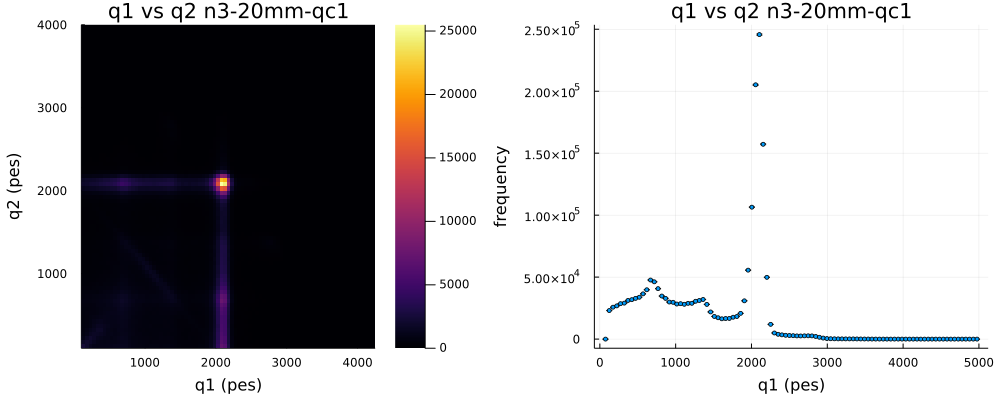

In [15]:
ANema.q1vsq2(ndf, tit="q1 vs q2 $conf", filename=joinpath(pathp, "q1q2"), save=true)

In [16]:
@printf "fraction of events with 2 pe = %5.2g" nrow(ndf) / norm

fraction of events with 2 pe =  0.39

## Cut in (q1,q2) 

In [17]:
ndfq =ANema.selectinterval(ndf, "q1", "q2", 1900.0, 2300.0);
println("after q1q2 cut: ndfq has a length of ", nrow(ndfq))
@printf "fraction of events q1q2 = %5.2g" nrow(ndfq) / norm

after q1q2 cut: ndfq has a length of 321582
fraction of events q1q2 = 0.064

In [18]:
ndfqp =select_by_column_value(ndfq, "phot1", true)
println("photoelectric selection: ndfqp has a length of ", nrow(ndfqp))
@printf "fraction of events q1q2/PHOT = %5.2g" nrow(ndfqp) / norm

photoelectric selection: ndfqp has a length of 117508
fraction of events q1q2/PHOT = 0.024

In [19]:
ndfqc =select_by_column_value(ndfq, "phot1", false)
println("compton selection: ndfqc has a length of ", nrow(ndfqc))
@printf "fraction of events q1q2/COMPT = %5.2g" nrow(ndfqc) / norm

compton selection: ndfqc has a length of 204074
fraction of events q1q2/COMPT = 0.041

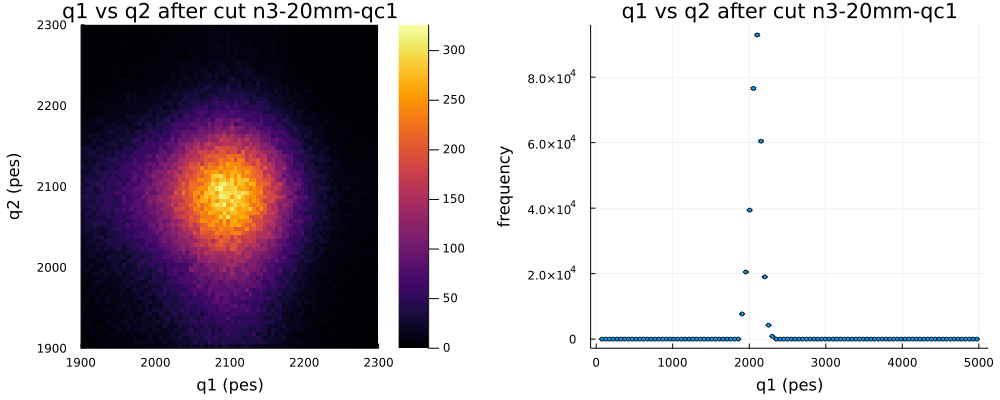

In [20]:
ANema.q1vsq2(ndfq, tit="q1 vs q2 after cut $conf", 
filename=joinpath(pathp, "q1q2-qcut"), save=true)

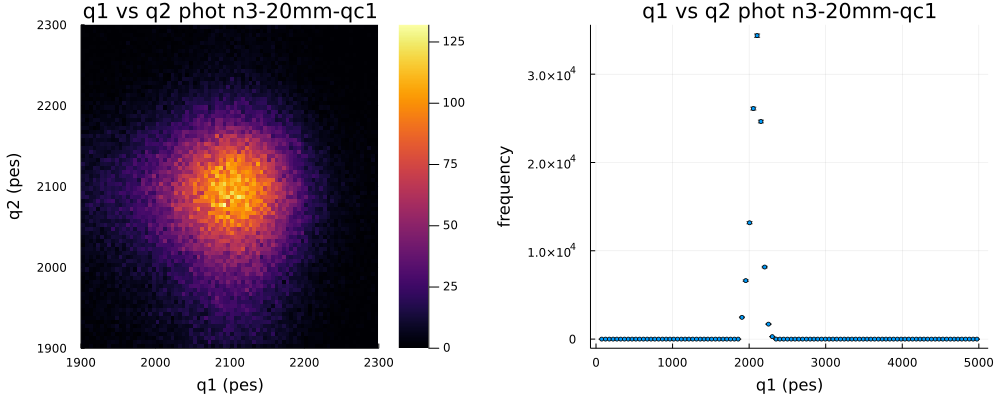

In [21]:
ANema.q1vsq2(ndfqp, tit="q1 vs q2 phot $conf", 
filename=joinpath(pathp, "q1q2-qcut-phot"), save=true)

### radial distribution of events

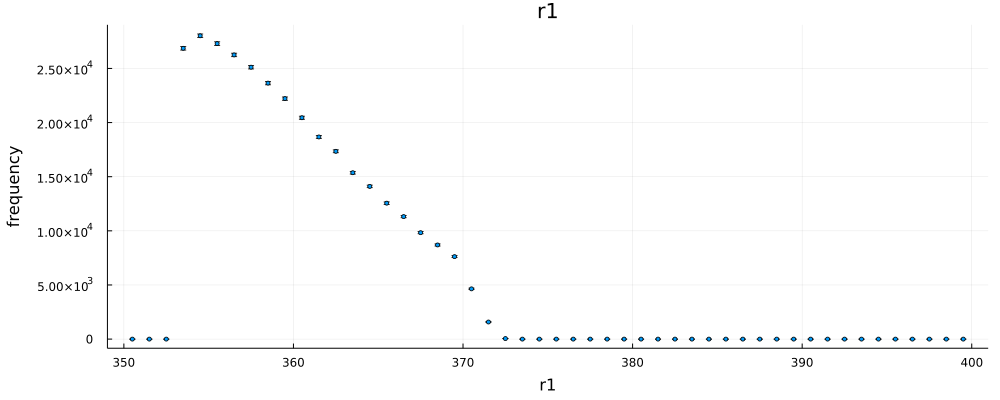

In [22]:
hr1,pr1 = hist1d(ndfq.r1, "r1", 50, 350.,400.0)
plot(pr1, layout= (1, 1), title="r1",  fmt = :png, size = (1000, 400),
            left_margin=5Plots.mm, right_margin=1Plots.mm, bottom_margin=5Plots.mm)

### Correlation coeficient 

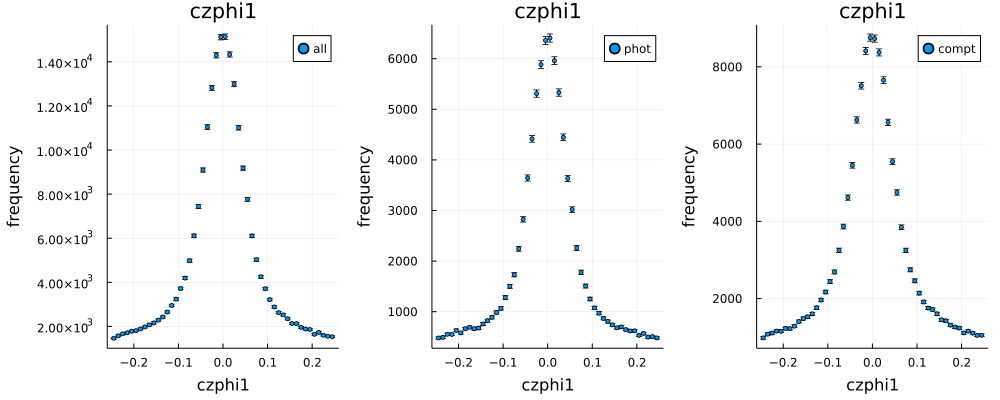

In [23]:
h1,p1 = hist1d(ndfq.corrzphi1, "czphi1", 50, -0.25,0.25, label="all")
h2,p2 = hist1d(ndfqp.corrzphi1, "czphi1", 50, -0.25,0.25, label="phot")
h3,p3 = hist1d(ndfqc.corrzphi1, "czphi1", 50, -0.25,0.25, label="compt")

plot(p1,p2,p3, layout= (1, 3),  title="czphi1", legend=true, fmt = :png, size = (1000, 400),
            left_margin=5Plots.mm, right_margin=1Plots.mm, bottom_margin=5Plots.mm)

 Czphi All:  σ = 0.051 mm Czphi Phot: σ = 0.047 mm Czphi ALL:  σ = 0.054 mm

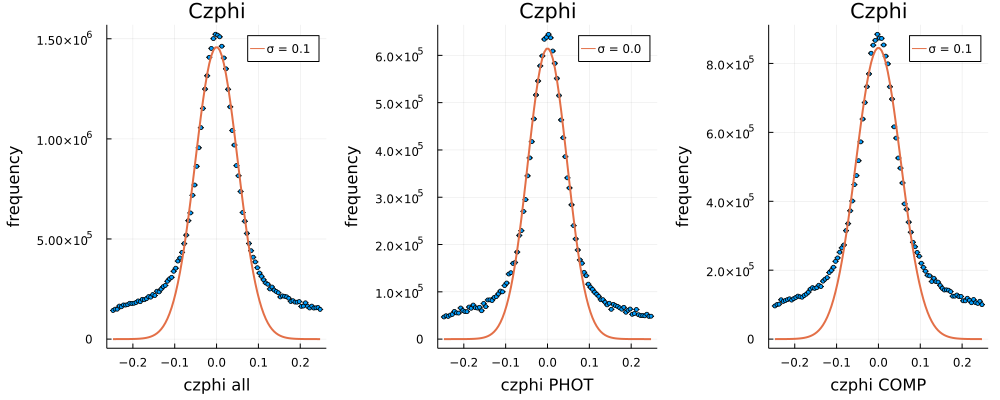

In [24]:
fg1,p1 = fitg1(ndfq.corrzphi1, "czphi all", 100, -0.25,0.25, xgmin=-0.1, xgmax=0.1)
fg2,p2 = fitg1(ndfqp.corrzphi1, "czphi PHOT", 100, -0.25,0.25, xgmin=-0.1, xgmax=0.1)
fg3,p3 = fitg1(ndfqc.corrzphi1, "czphi COMP", 100, -0.25,0.25, xgmin=-0.1, xgmax=0.1)
@printf " Czphi All:  σ = %5.3f mm" fg1.std[1] 
@printf " Czphi Phot: σ = %5.3f mm" fg2.std[1] 
@printf " Czphi ALL:  σ = %5.3f mm" fg3.std[1] 
ANema.plot_and_save(p1,p2, p3, "Czphi", joinpath(pathp, "Czphi")) 

### Summary: no separation using Czphi between Compton and Photoelectric

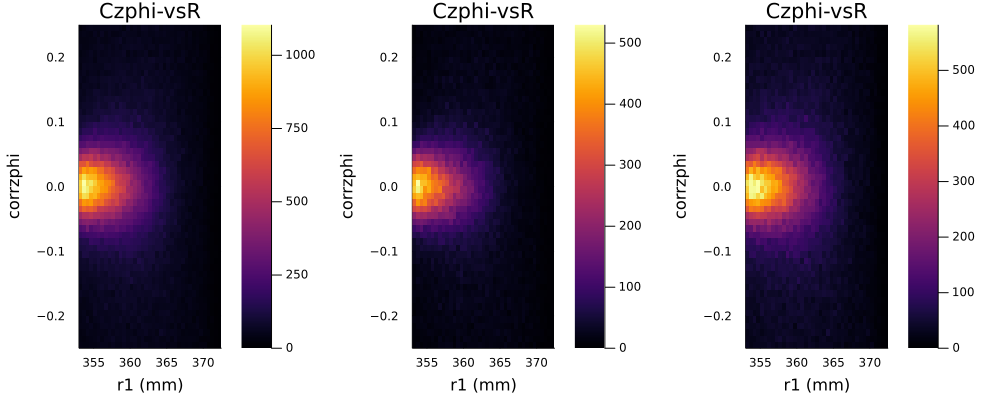

In [25]:
h1,p1 = hist2d(ndfq.r1, ndfq.corrzphi1, 50, "r1 (mm)","corrzphi",  350.0, 400.0, -0.25, 0.25)
h2,p2 = hist2d(ndfqp.r1, ndfqp.corrzphi1, 50, "r1 (mm)","corrzphi",  350.0, 400.0, -0.25, 0.25)
h3,p3 = hist2d(ndfqc.r1, ndfqc.corrzphi1, 50, "r1 (mm)","corrzphi",  350.0, 400.0, -0.25, 0.25)

ANema.plot_and_save(p1,p2, p3, "Czphi-vsR", joinpath(pathp, "Czphi-R"))

### zstd vs phistd

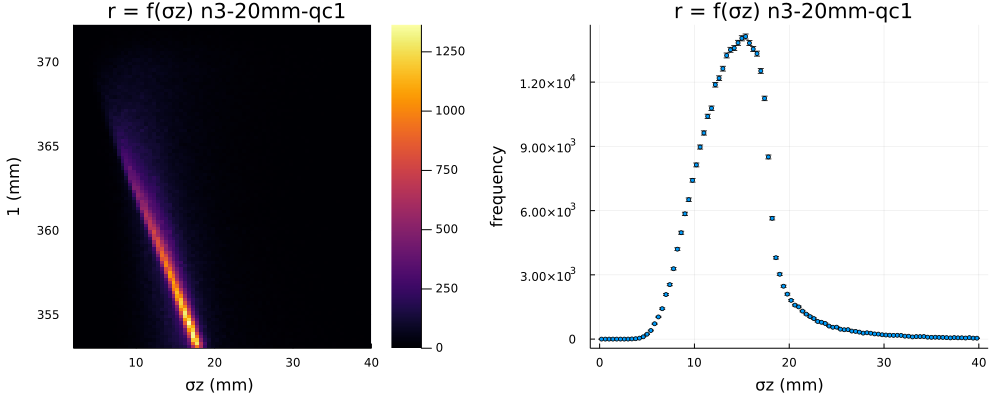

In [26]:
ANema.zstd(ndfq, 100, 0.0, 40.0,350.0, 400.0,tit=" r = f(σz) $conf", filename=joinpath(pathp, "zstd"), save=true)

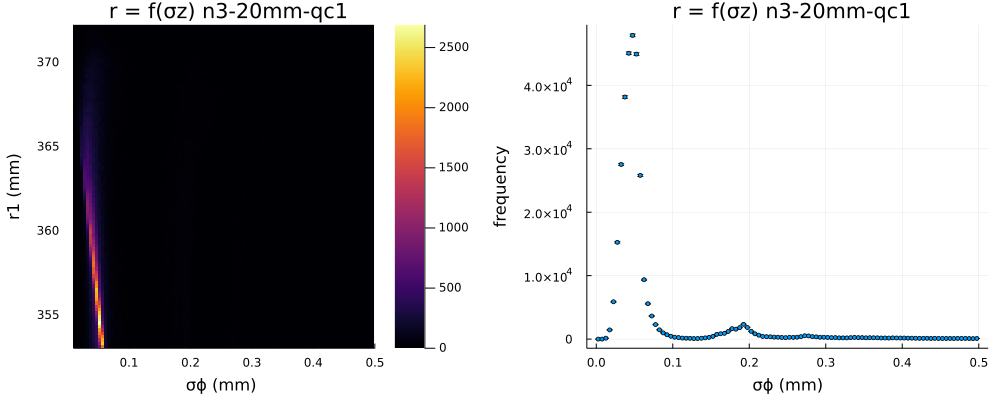

In [27]:
ANema.phistd(ndfq, 100, 0.0, 0.5, 350.0,400.0, tit=" r = f(σz) $conf", filename=joinpath(pathp, "zstd"), save=true)

In [28]:
ndfz =ANema.selectinterval(ndfq, "zstd1", "zstd2", 0.0, 30.0);
println("after zstd cut: ndfz has a length of ", nrow(ndfz))
@printf "fraction of events nz = %5.2g" nrow(ndfz) / norm

after zstd cut: ndfz has a length of 309753
fraction of events nz = 0.062

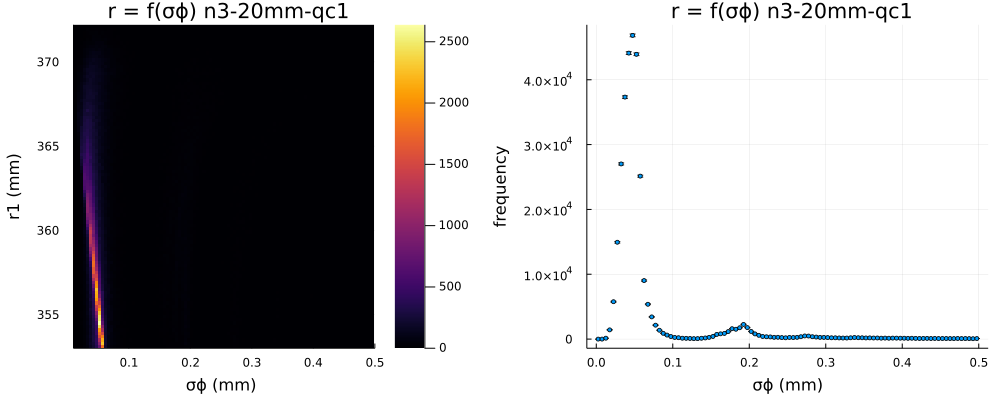

In [29]:
ANema.phistd(ndfz, 100, 0.0, 0.5, 350.0,400.0, tit=" r = f(σϕ) $conf", filename=joinpath(pathp, "phistd"), save=true)

In [30]:
ndfp =ANema.selectinterval(ndfq, "phistd1", "phistd2", 0.001, 0.10);
println("after pstd cut: ndfz has a length of ", nrow(ndfp))
@printf "fraction of events np = %5.2g" nrow(ndfp) / norm

after pstd cut: ndfz has a length of 230770
fraction of events np = 0.046

In [31]:
ndfpz =ANema.selectinterval(ndfz, "phistd1", "phistd2", 0.001, 0.5);
println("after pstd cut: ndfz has a length of ", nrow(ndfpz))
@printf "fraction of events np = %5.2g" nrow(ndfpz) / norm

after pstd cut: ndfz has a length of 285603
fraction of events np = 0.057

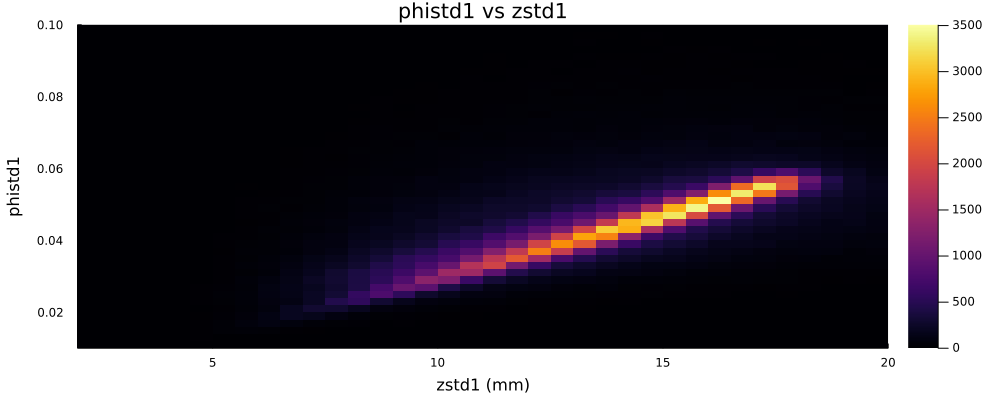

In [33]:
h2,p2 = hist2d(ndfpz.zstd1, ndfpz.phistd1, 50, "zstd1 (mm)","phistd1", 0.0, 20.0, 0., 0.1)
plot(p2, layout= (1, 1), title="phistd1 vs zstd1",  fmt = :png, size = (1000, 400),
            left_margin=5Plots.mm, right_margin=1Plots.mm, bottom_margin=5Plots.mm)

### zstd and phistd are fully correlated. There is no extra information in their combination. 

### Selection in terms of zstd (better behaved than phistd, no oscillations)

In [34]:
ndfz =ANema.selectinterval(ndfq, "zstd1", "zstd2", 1.0, 30.0);
println("after zstd cut: ndfz has a length of ", nrow(ndfz))
@printf "fraction of events np = %5.2g" nrow(ndfz) / norm

after zstd cut: ndfz has a length of 309753
fraction of events np = 0.062

Fit parameters: a = 364.0 b = -38.5 Fit errors: a =     1 b = 2e+01 

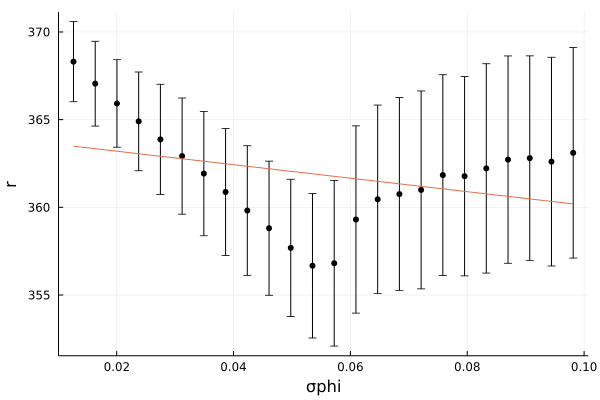

In [49]:
fp1, pp1 = fit_profile(ndfp.phistd1, ndfp.r1, "σphi", "r", "pol1")
fpars = fp1.fitpar
fstds = fp1.fitstd
@printf "Fit parameters: a = %5.1f b = %5.1f " fpars[1] fpars[2]
@printf "Fit errors: a = %5.1g b = %5.1g " fstds[1] fstds[2]
plot(pp1)

Fit parameters: a = 366.6 b =  -0.3 Fit errors: a =     1 b =  0.07 

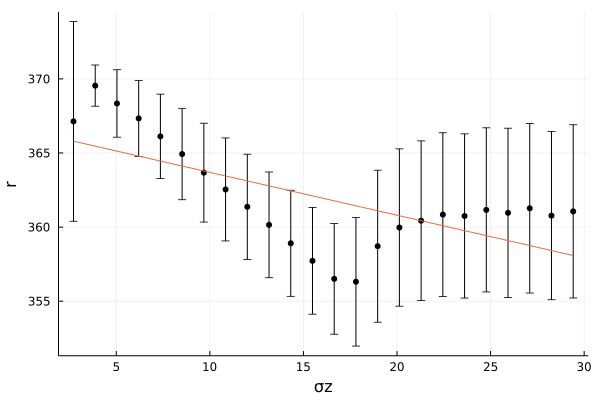

In [35]:
fz1, pz1 = fit_profile(ndfz.zstd1, ndfz.r1, "σz", "r", "pol1")
fpars = fz1.fitpar
fstds = fz1.fitstd
@printf "Fit parameters: a = %5.1f b = %5.1f " fpars[1] fpars[2]
@printf "Fit errors: a = %5.1g b = %5.1g " fstds[1] fstds[2]
plot(pz1)

### Bad fit for large values of zstd

In [102]:
ndfz =ANema.selectinterval(ndfq, "zstd1", "zstd2", 5.0, 18.0);
println("after zstd cut: ndfz has a length of ", nrow(ndfz))
@printf "fraction of events np = %5.2g" nrow(ndfz) / norm

after zstd cut: ndfz has a length of 247922
fraction of events np =  0.05

Fit parameters: a = 373.70 b = -1.03 Fit errors: a =   0.1 b = 0.0086 

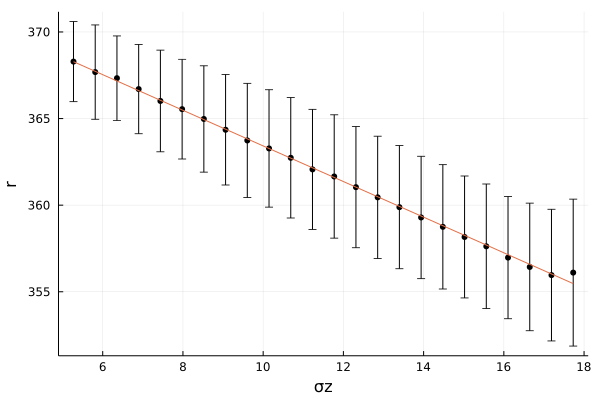

In [103]:
fz1, pz1 = fit_profile(ndfz.zstd1, ndfz.r1, "σz", "r", "pol1")
fpars = fz1.fitpar
fstds = fz1.fitstd
@printf "Fit parameters: a = %5.2f b = %5.2f " fpars[1] fpars[2]
@printf "Fit errors: a = %5.2g b = %5.2g " fstds[1] fstds[2]
plot(pz1)

Fit parameters: a = 373.0 b =  -0.9 Fit errors: a =   0.2 b =  0.01 

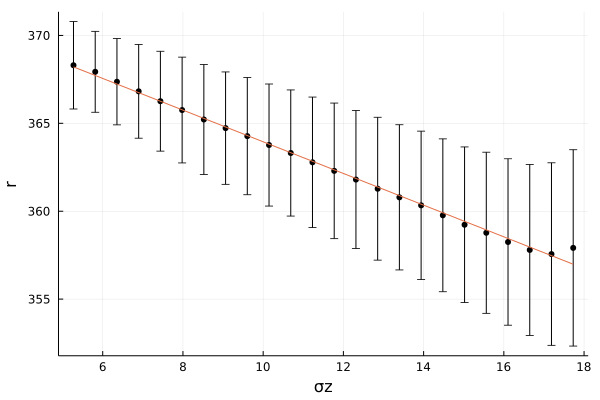

In [104]:
fz2, pz2 = fit_profile(ndfz.zstd2, ndfz.r2, "σz", "r", "pol1")
fpars = fz2.fitpar
fstds = fz2.fitstd
@printf "Fit parameters: a = %5.1f b = %5.1f " fpars[1] fpars[2]
@printf "Fit errors: a = %5.1g b = %5.1g " fstds[1] fstds[2]
plot(pz2)

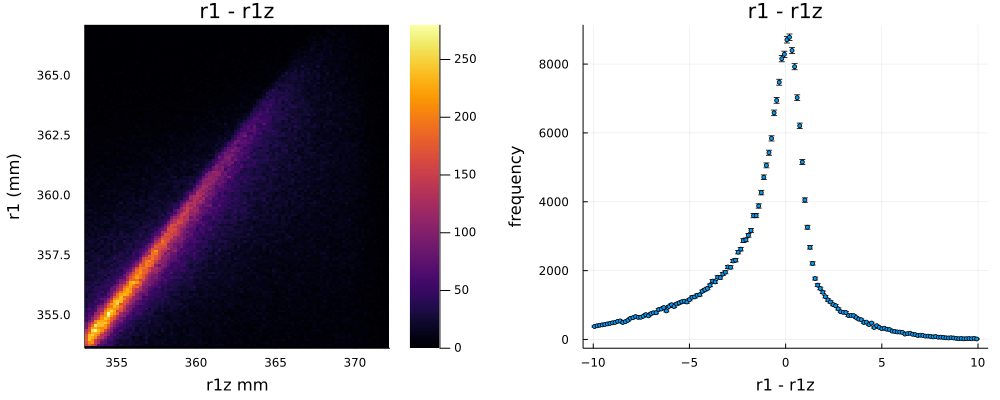

In [105]:
r1z = fz1.g.(ndfz.zstd1) - 1.5 * ones(length(ndfz.q1)) ; 
ANema.plotreso(r1z, ndfz.r1, "r1z mm", "r1 (mm)", -10., 10.0, tit="r1 - r1z", 
         filename=filename=joinpath(pathp, "r1-r1z"), save=true)


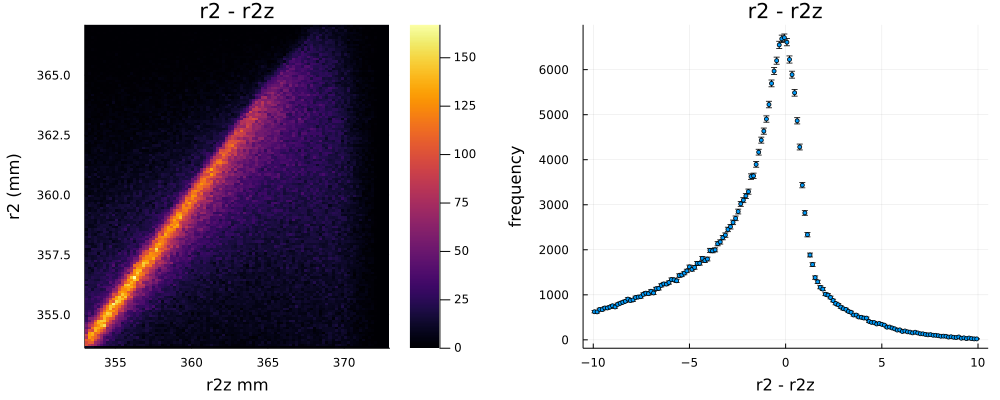

In [106]:
r2z = fz1.g.(ndfz.zstd2) - 1.5 * ones(length(ndfz.q2)) ; 
ANema.plotreso(r2z, ndfz.r2, "r2z mm", "r2 (mm)", -10., 10.0, tit="r2 - r2z", 
         filename=filename=joinpath(pathp, "r2-r2z"), save=true)


 σ =     1.1 mm

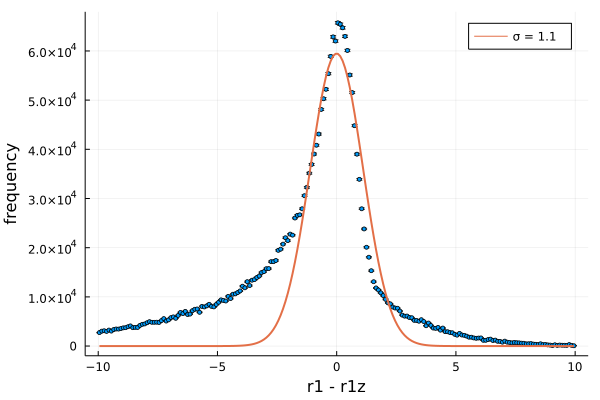

In [107]:
fg,p = fitg1(r1z - ndfz.r1, "r1 - r1z", 200, -10.0, 10.0, xgmin=-2.5, xgmax=2.5)
@printf " σ = %7.1f mm" fg.std[1] 
ANema.pout(p,joinpath(pathp, "zstd-fitg1"))
plot(p)

r-rz σ1 =   3.881 σ2 =   0.765

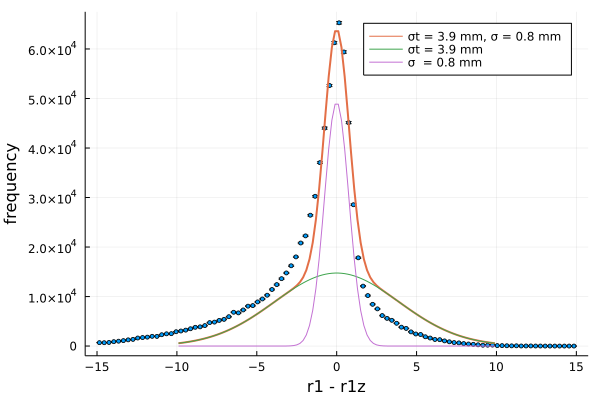

In [108]:
fg, p = fitg2(r1z - ndfz.r1, "r1 - r1z", 100, -15.0, 15.0, 
                      xg1min=-10.0, xg1max=-1.5, 
                      xg2min=-1.5,  xg2max =1.5, 
                      xgmin =-10.0, xgmax  =10.0)
@printf "r-rz σ1 = %7.3f σ2 = %7.3f" fg.std[1] fg.std[2]
ANema.pout(p, joinpath(pathp, "zstd-fitg2"))
plot(p)

r-rz σ1 =   4.598 σ2 =   0.816

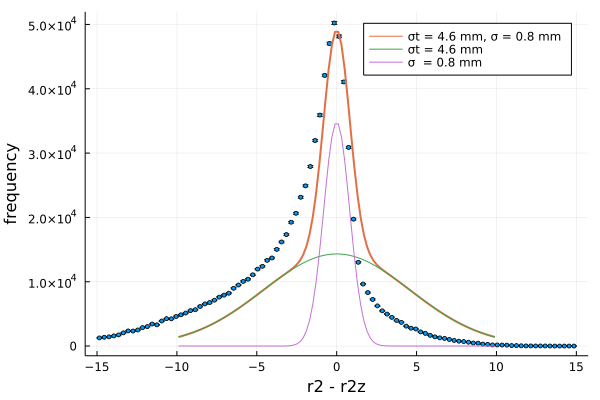

In [109]:
fg, p = fitg2(r2z - ndfz.r2, "r2 - r2z", 100, -15.0, 15.0, 
                      xg1min=-10.0, xg1max=-1.5, 
                      xg2min=-1.5,  xg2max =1.5, 
                      xgmin =-10.0, xgmax  =10.0)
@printf "r-rz σ1 = %7.3f σ2 = %7.3f" fg.std[1] fg.std[2]
ANema.pout(p, joinpath(pathp, "zstd-fitg2"))
plot(p)

In [110]:
println("number of  events recorded ", nrow(ndf))
println("number of  events q ϵ (qmin, qmax) ", nrow(ndfq))
println("number of  events zstd ϵ (zstd_min, zstd_max) ", nrow(ndfz))
println("fraction os useful events ", nrow(ndfz) / norm)

number of  events recorded 1932321
number of  events q ϵ (qmin, qmax) 321582
number of  events zstd ϵ (zstd_min, zstd_max) 247922
fraction os useful events 0.0495844


In [118]:
println("fraction of  events recorded ", nrow(ndf)/norm)
println("fraction of  events q ϵ (qmin, qmax) ", nrow(ndfq)/norm)
println("fraction of  events zstd ϵ (zstd_min, zstd_max) ", nrow(ndfz)/norm)

fraction of  events recorded 0.3864642
fraction of  events q ϵ (qmin, qmax) 0.0643164
fraction of  events zstd ϵ (zstd_min, zstd_max) 0.0495844


## Resolution in (x,y,z,r) intrinsic

 σx =     0.3 mm σy =     0.2 mm σz =     0.5 mm

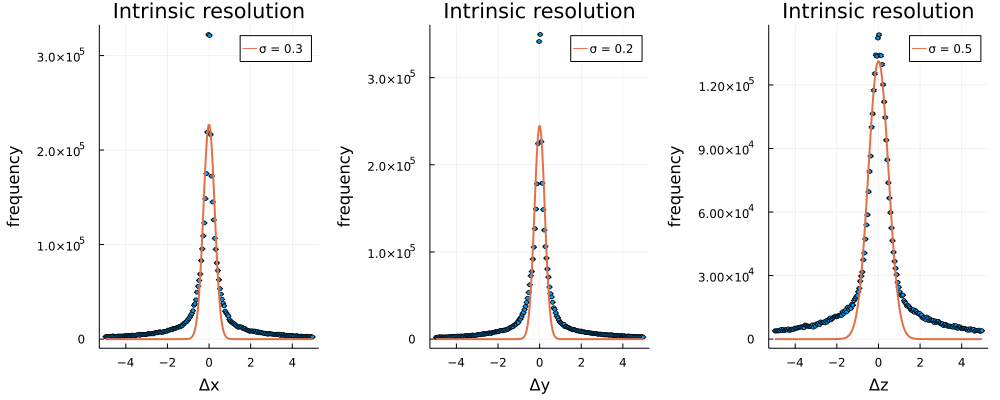

In [111]:
fg,px = fitg1(ndfz.xt1 - ndfz.x1, "Δx", 200, -5.0, 5.0, xgmin=-1.5, xgmax=1.5)
@printf " σx = %7.1f mm" fg.std[1]
fg,py = fitg1(ndfz.yt1 - ndfz.y1, "Δy", 200, -5.0, 5.0, xgmin=-1.5, xgmax=1.5)
@printf " σy = %7.1f mm" fg.std[1]
fg,pz = fitg1(ndfz.zt1 - ndfz.z1, "Δz", 200, -5.0, 5.0, xgmin=-1.5, xgmax=1.5)
@printf " σz = %7.1f mm" fg.std[1]
ANema.plot_and_save(px,py, pz, "Intrinsic resolution", joinpath(pathp, "Intrinsic-res")) 

## Resolución reco

## Position from best estimator (r1z)

In [112]:
xz1,yz1,zz1 = ANema.radial_correction(ndfz.xr1, ndfz.yr1, ndfz.zr1, r1z);
xz2,yz2,zz2 = ANema.radial_correction(ndfz.xr2, ndfz.yr2, ndfz.zr2, r2z);

 σx1 =  0.91 mm σy1 =  0.92 mm σz =  0.49 mm

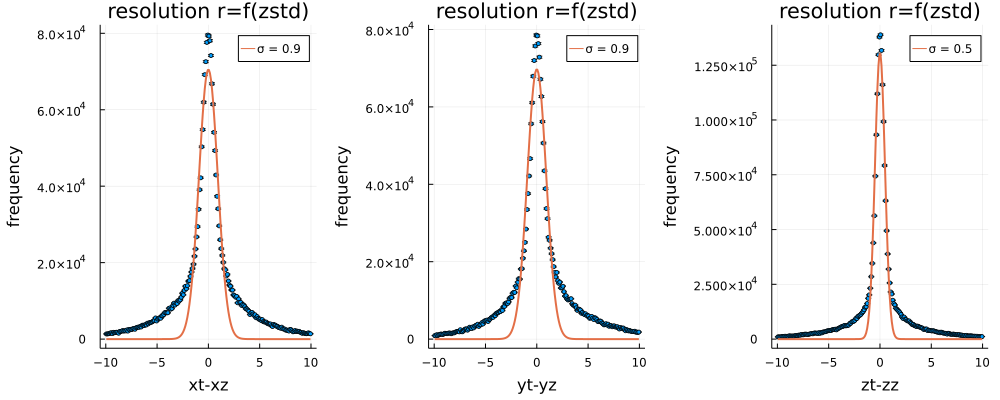

In [113]:
fg,pzx1 = fitg1(ndfz.xt1 - xz1, "xt-xz", 200, -10.0, 10.0, xgmin=-2.5, xgmax=2.5)
@printf " σx1 = %5.2f mm" fg.std[1] 
fg,pzy1 = fitg1(ndfz.yt1 - yz1, "yt-yz", 200, -10.0, 10.0, xgmin=-2.5, xgmax=2.5)
@printf " σy1 = %5.2f mm" fg.std[1] 
fg,pzz1 = fitg1(ndfz.zt1 - zz1, "zt-zz", 200, -10.0, 10.0, xgmin=-2.5, xgmax=2.5)
@printf " σz = %5.2f mm" fg.std[1]
ANema.plot_and_save(pzx1,pzy1, pzz1, "resolution r=f(zstd)", joinpath(pathp, "zstd-res-r1")) 

σ1 =  3.58 σ2 = 0.617, δx =  1.42
σ1 =  3.62 σ2 =  0.63, δy =  1.44
σ1 =  2.90 σ2 =  0.40, δz =  0.92

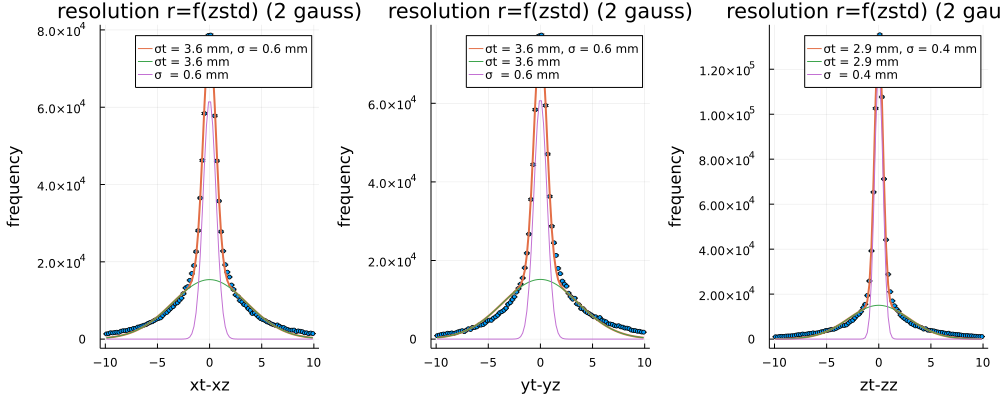

In [114]:
fgx, px = fitg2(ndfz.xt1 - xz1, "xt-xz", 100, -10.0, 10.0, 
                      xg1min=-10.0, xg1max=-2.5, 
                      xg2min=-2.5,  xg2max =2.5, 
                      xgmin =-10.0, xgmax  =10.0)
fgy, py = fitg2(ndfz.yt1 - yz1, "yt-yz", 100, -10.0, 10.0, 
                xg1min=-10.0, xg1max=-2.5, 
                xg2min=-2.5,  xg2max =2.5, 
                xgmin =-10.0, xgmax  =10.0)
fgz, pz = fitg2(ndfz.zt1 - zz1, "zt-zz", 100, -10.0, 10.0, 
                xg1min=-10.0, xg1max=-2.5, 
                xg2min=-2.5,  xg2max =2.5, 
                xgmin =-10.0, xgmax  =10.0)
@printf "σ1 = %5.2f σ2 = %5.3f, δx = %5.2f\n" fgx.std[1] fgx.std[2] 2.3*fgx.std[2]
@printf "σ1 = %5.2f σ2 = %5.2f, δy = %5.2f\n" fgy.std[1] fgy.std[2] 2.3*fgy.std[2]
@printf "σ1 = %5.2f σ2 = %5.2f, δz = %5.2f" fgz.std[1] fgz.std[2] 2.3*fgz.std[2]
ANema.plot_and_save(px,py, pz, "resolution r=f(zstd) (2 gauss)", joinpath(pathp, "zstd-res-2g")) 

 σx1 =  1.26 mm σy1 =  1.30 mm σz =  0.46 mm

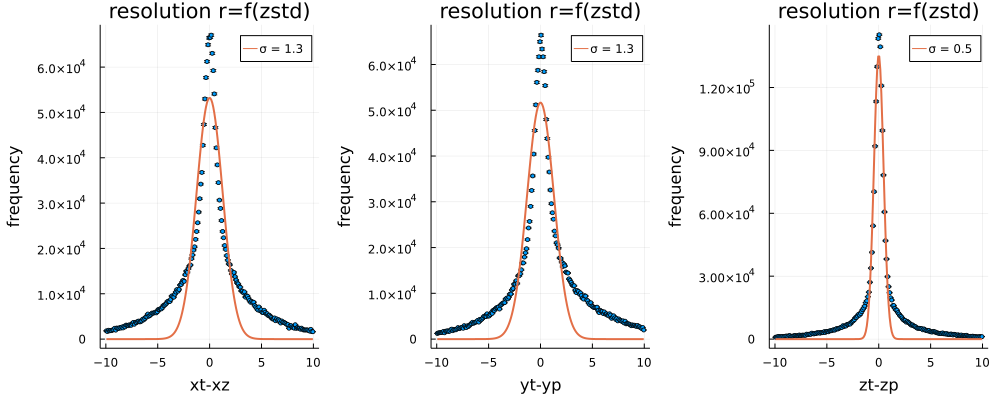

In [115]:
fg,pzx2 = fitg1(ndfz.xt2 - xz2, "xt-xz", 200, -10.0, 10.0, xgmin=-5.0, xgmax=5.0)
@printf " σx1 = %5.2f mm" fg.std[1] 
fg,pzy2 = fitg1(ndfz.yt2 - yz2, "yt-yp", 200, -10.0, 10.0, xgmin=-5.0, xgmax=5.0)
@printf " σy1 = %5.2f mm" fg.std[1] 
fg,pzz2 = fitg1(ndfz.zt2 - zz2, "zt-zp", 200, -10.0, 10.0, xgmin=-5.0, xgmax=5.0)
@printf " σz = %5.2f mm" fg.std[1]
ANema.plot_and_save(pzx2,pzy2, pzz2, "resolution r=f(zstd)", joinpath(pathp, "zstd-res-r2")) 

σ1 =  3.87 σ2 = 0.632, δx =  1.45
σ1 =  3.99 σ2 =  0.65, δy =  1.50
σ1 =  2.66 σ2 =  0.38, δz =  0.87

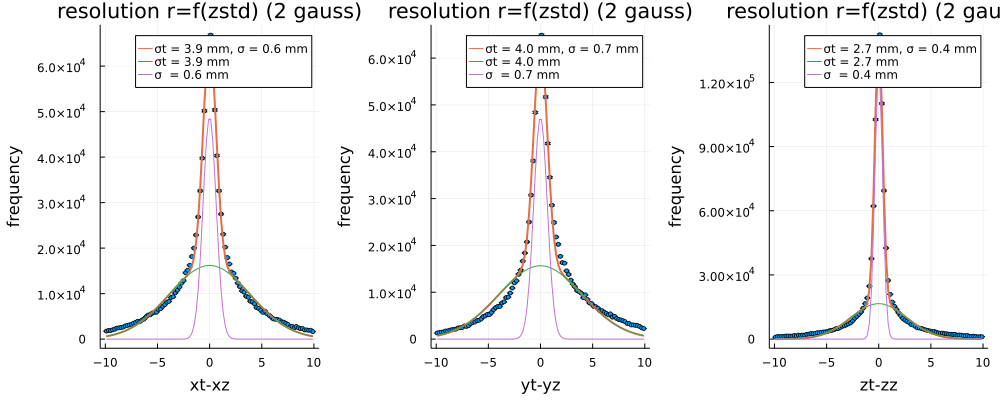

In [116]:
fgx, px = fitg2(ndfz.xt2 - xz2, "xt-xz", 100, -10.0, 10.0, 
                      xg1min=-10.0, xg1max=-2.5, 
                      xg2min=-2.5,  xg2max =2.5, 
                      xgmin =-10.0, xgmax  =10.0)
fgy, py = fitg2(ndfz.yt2 - yz2, "yt-yz", 100, -10.0, 10.0, 
                xg1min=-10.0, xg1max=-2.5, 
                xg2min=-2.5,  xg2max =2.5, 
                xgmin =-10.0, xgmax  =10.0)
fgz, pz = fitg2(ndfz.zt2 - zz2, "zt-zz", 100, -10.0, 10.0, 
                xg1min=-10.0, xg1max=-2.5, 
                xg2min=-2.5,  xg2max =2.5, 
                xgmin =-10.0, xgmax  =10.0)
@printf "σ1 = %5.2f σ2 = %5.3f, δx = %5.2f\n" fgx.std[1] fgx.std[2] 2.3*fgx.std[2]
@printf "σ1 = %5.2f σ2 = %5.2f, δy = %5.2f\n" fgy.std[1] fgy.std[2] 2.3*fgy.std[2]
@printf "σ1 = %5.2f σ2 = %5.2f, δz = %5.2f" fgz.std[1] fgz.std[2] 2.3*fgz.std[2]
ANema.plot_and_save(px,py, pz, "resolution r=f(zstd) (2 gauss)", joinpath(pathp, "zstd-res-2g")) 

## Summary: resolution in (X,Y,Z) for DOI events:
- Resolution ~2.2 mm, better in z, tails. How does that affect image resolution?

In [74]:
ndfz[!,"r1x"] = r1z;
ndfz[!,"r2x"] = r2z;

## TOF

In [75]:
dfz = ANema.setunits(ndfz);

In [76]:
dt12 = ANema.deltatime(dfz, ANema.dtfirst);

In [77]:
t12 = dt12./ps;
@printf " mean t12 = %5.2f std = %5.2f" mean(t12) std(t12)

 mean t12 = -12.15 std = 661.73

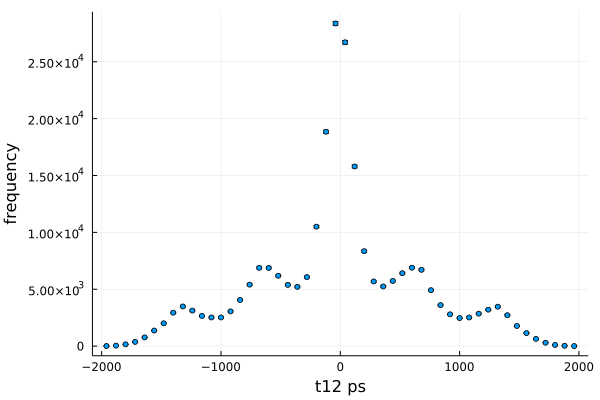

In [78]:
h,p       = hist1d(t12, "t12 ps", 50,  -2000., 2000.)
plot(p)

 mean t12 = -18.63 std = 102.39

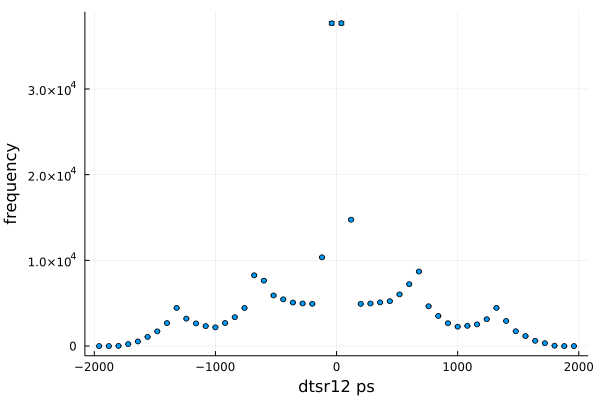

In [79]:
dtsr12 = ANema.ctsr(dfz, ANema.postrue)
tsr12 = dtsr12./ps
@printf " mean t12 = %5.2f std = %5.2f" mean(t12 - tsr12) std(t12 -tsr12)
h,p       = ANema.hist1d(tsr12, "dtsr12 ps", 50,  -2000., 2000.)
plot(p)

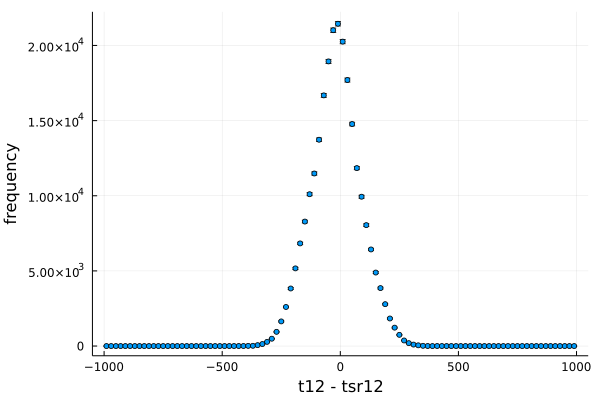

In [80]:
h,p       = hist1d(t12-tsr12, "t12 - tsr12", 100,  -1000., 1000.)
plot(p)

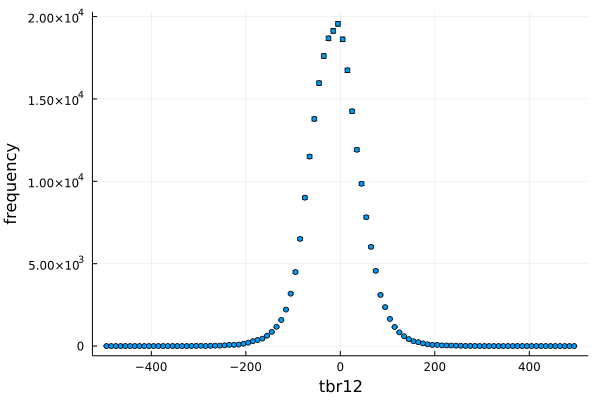

In [81]:
dtrb12 = ANema.cdoi(dfz,  ANema.postrue);
trb12  = dtrb12 ./ps
h,p    = hist1d(trb12, "tbr12", 100,  -500., 500.)
plot(p)

 mean t12 = -7.01 std = 84.94

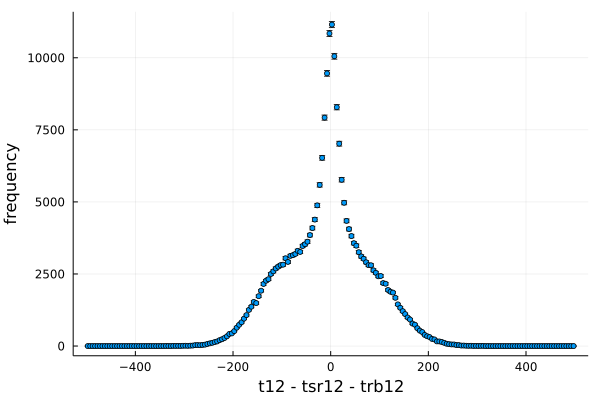

In [82]:
h,p       = hist1d(t12 - tsr12 - trb12  , "t12 - tsr12 - trb12", 200,  -500., 500.)
@printf " mean t12 = %5.2f std = %5.2f" mean(t12 - tsr12 - trb12) std(t12 - tsr12 - trb12)
plot(p)

sigma1 =  99.509 sigma2 =  13.094

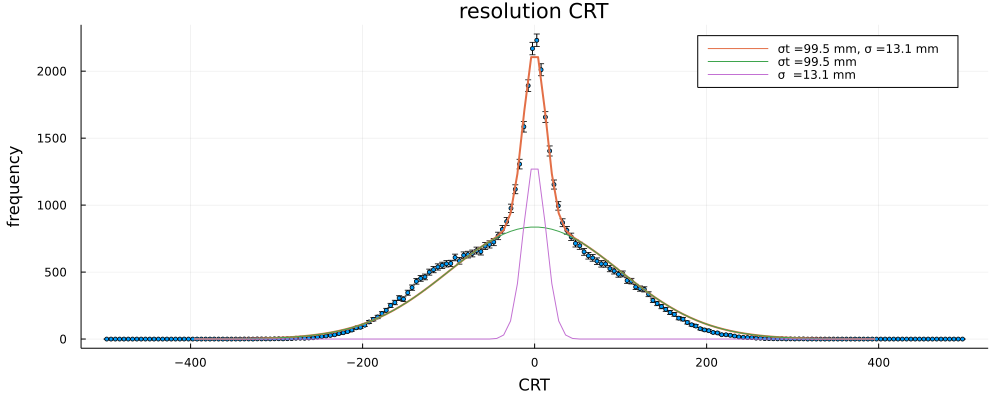

In [83]:
dt = t12 - tsr12 - trb12;
fg, p = fitg2(dt, "CRT", 200, -500.0, 500.0, 
                      xg1min=-400.0, xg1max=-50.0, 
                      xg2min=-50.0,  xg2max =50.0, 
                      xgmin =-400.0, xgmax  =400.0)
@printf "sigma1 = %7.3f sigma2 = %7.3f" fg.std[1] fg.std[2]
ANema.plot_and_save(p, "resolution CRT", joinpath(pathp, "CRT")) 

First photon, position true: FWHM1 = 228.870 FWHM2 =  30.117

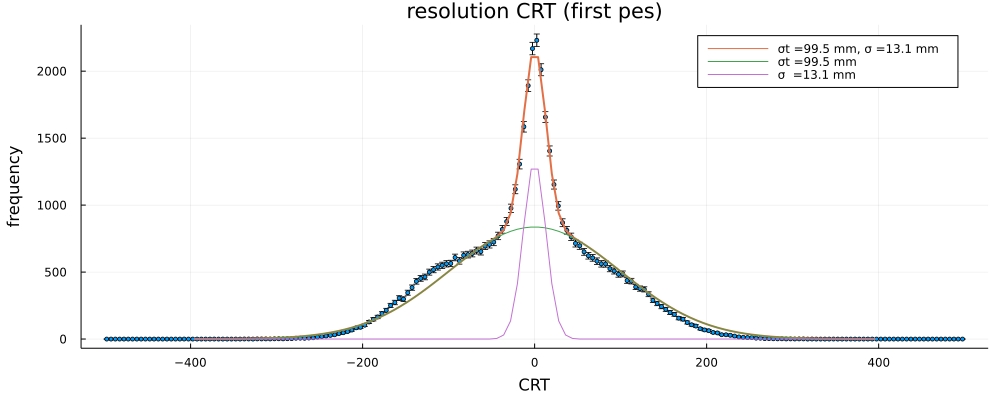

In [84]:
dt = ANema.crt(dfz, ANema.dtfirst,ANema.postrue)
fg, p = fitg2(dt, "CRT", 200, -500.0, 500.0, 
                      xg1min=-400.0, xg1max=-50.0, 
                      xg2min=-50.0,  xg2max =50.0, 
                      xgmin =-400.0, xgmax  =400.0)
@printf "First photon, position true: FWHM1 = %7.3f FWHM2 = %7.3f" 2.3*fg.std[1] 2.3*fg.std[2]
ANema.plot_and_save(p, "resolution CRT (first pes)", joinpath(pathp, "CRT-fastest")) 

fastest photoelectron, position reco: FWHM = 232.419

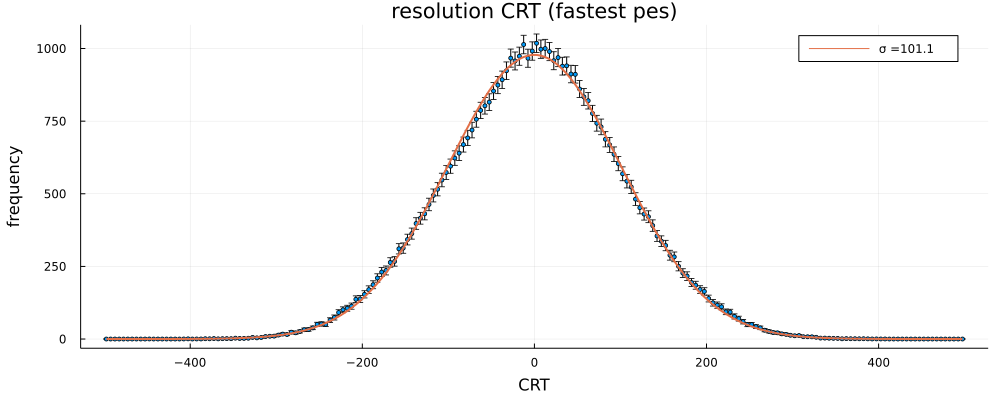

In [85]:
dt = ANema.crt(dfz,  ANema.dtminimum, ANema.postrue)
fg,p = fitg1(dt.+10.0, "CRT", 200, -500.0, 500.0,  
                     xgmin=-400.0, xgmax=400.0)
@printf "fastest photoelectron, position reco: FWHM = %7.3f" 2.3*fg.std[1] 
ANema.plot_and_save(p, "resolution CRT (fastest pes)", joinpath(pathp, "CRT-fastest")) 

fastest photoelectron, position reco: FWHM = 233.233

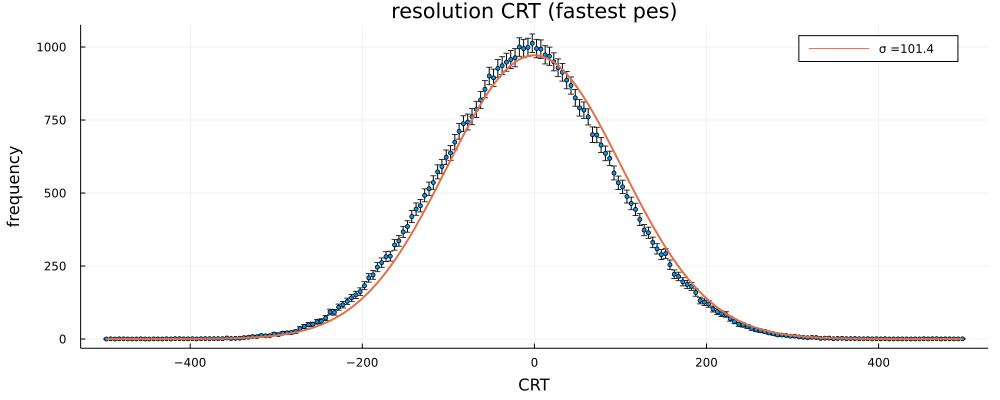

In [86]:
dt = ANema.crt(dfz, ANema.dtminimum,ANema.posreco)
fg,p = ANema.fitg1(dt, "CRT", 200, -500.0, 500.0,  
                     xgmin=-400.0, xgmax=400.0)
@printf "fastest photoelectron, position reco: FWHM = %7.3f" 2.3*fg.std[1] 
ANema.plot_and_save(p, "resolution CRT (fastest pes)", joinpath(pathp, "CRT-fastest-reco")) 

average photoelectron, position reco: FWHM = 224.772

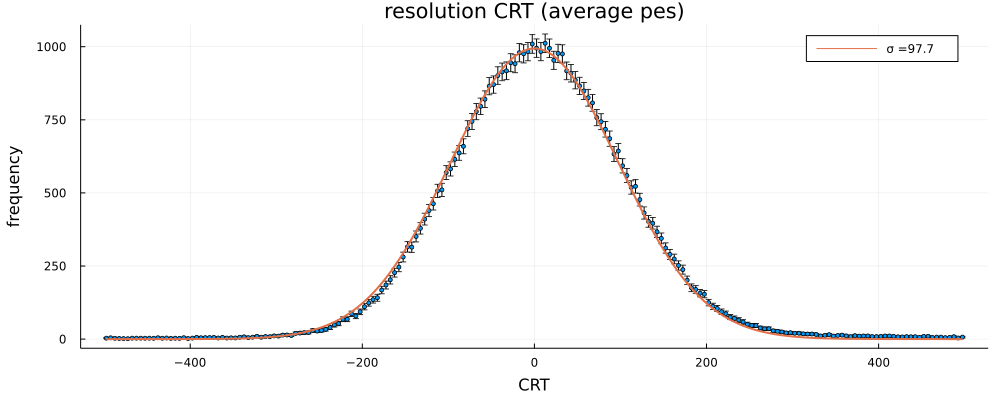

In [87]:
dt = ANema.crt(dfz, ANema.dtaverage,ANema.posreco)
fg,p = fitg1(dt.+10.0, "CRT", 200, -500.0, 500.0,  
                     xgmin=-400.0, xgmax=400.0)
@printf "average photoelectron, position reco: FWHM = %7.3f" 2.3*fg.std[1] 
ANema.plot_and_save(p, "resolution CRT (average pes)", joinpath(pathp, "CRT-average-reco")) 

average photoelectron, position reco: FWHM = 233.473

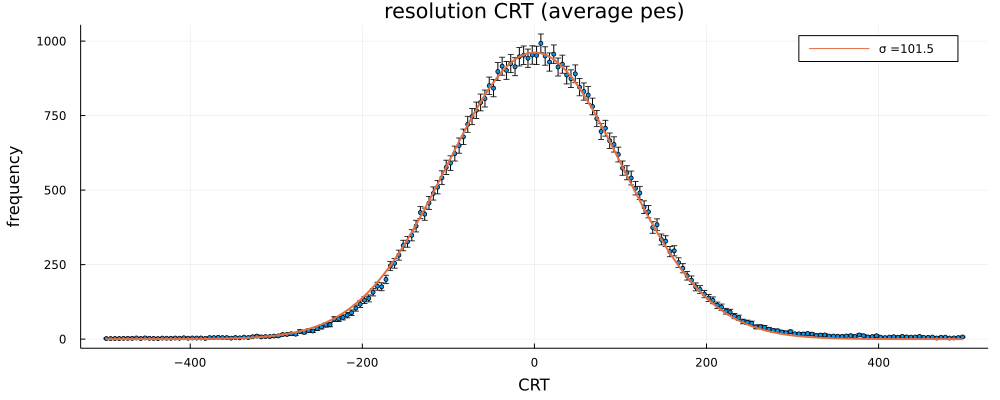

In [117]:
dt = ANema.crt(dfz, ANema.dtaverage,ANema.posrecall)
fg,p = fitg1(dt.+10.0, "CRT", 200, -500.0, 500.0,  
                     xgmin=-400.0, xgmax=400.0)
@printf "average photoelectron, position reco: FWHM = %7.3f" 2.3*fg.std[1] 
ANema.plot_and_save(p, "resolution CRT (average pes)", joinpath(pathp, "CRT-average-recall")) 

## Save

In [ ]:
ANema.writemdf(patho,"mdf-phistd-$conf.csv", ndfp)
ANema.writemdf(patho,"mdf-zstd-$conf.csv", ndfz)